### Chapter 15 - Qualifying and Acceptance Testing
Author: Ben Wilson
##### Section 4 - interpretability
This notebook covers model explainability (XAI) through the use of Python's shap package. 

In [1]:
%pip install optuna

Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install plotly==4.14.3

Note: you may need to restart the kernel to use updated packages.


In [3]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cmap
import math
import numpy as np

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import make_pipeline

import optuna
from optuna.visualization import plot_contour
from optuna.visualization import plot_edf
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_slice

import shap
from collections import namedtuple

In [4]:
DATA_URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/forest-fires/forestfires.csv"
COLS = ['x_coord', 'y_coord', 'month', 'day', 
         'fine_fuel_moisture_code', 'duff_moisture_code', 
         'drought_code', 'initial_spread_index', 'temperature', 
         'relative_humidity', 'windspeed', 'rain_amount', 'area']

In [5]:
class DataHandling:
    
    def __init__(self, file_name, columns):
        self.file_name = file_name
        self.columns = columns
        self.day_map = {'mon':0,'tue':1,'wed':2,'thu':3,'fri':4,'sat':5,'sun':6}

    def acquire_data(self, url):
        response = requests.get(url, stream=True)
        with open(self.file_name, "wb") as data:
            data.write(response.content)
        response.close()

    def _load_data(self):
        return pd.read_csv(self.file_name)
    
    @staticmethod
    def calculate_heat_index(t, h):
        f = ((t * 9/5) + 32)
        t2 = math.pow(f, 2)
        h2 = math.pow(h, 2)

        c = [ 0.363445176, 0.988622465, 4.777114035, -0.114037667, -0.000850208, -0.020716198, 0.000687678, 0.000274954, 0]

        heat_index =  c[0] + (c[1]*f) + (c[2]*h) + (c[3]*f*h) + (c[4]*t2) + (c[5]*h2) + (c[6]*t2*h) + (c[7]*f*h2) + (c[8]*t2*h2)

        return ((heat_index - 32) * 5/9)
    
    def get_fire_data(self):
        df = self._load_data()
        df.columns = self.columns
        df['month'] = pd.to_datetime(df.month, format='%b').dt.month
        df['day'] = df['day'].apply(lambda x: self.day_map[x])
        df['heat_index'] = df.apply(lambda x: self.calculate_heat_index(x['temperature'], x['relative_humidity']), axis=1)
        return df
        

In [6]:
class DataValidation:
    
    def __init__(self, data):
        self.data = data
        
    def plot_correlation(self):
        corr = self.data.corr()
        with plt.style.context('seaborn'):
            fig, ax = plt.subplots(figsize=(14, 12))
            sns.heatmap(corr, ax=ax, cmap=cmap.copper_r)
    
    def plot_pairwise(self):
        pd.plotting.scatter_matrix(self.data, figsize=(24,24))
    
    def plot_hist(self, feature, bins):
        with plt.style.context('seaborn'):
            fig, ax = plt.subplots(figsize=(14, 10))
            plt.hist(self.data[feature], bins=bins)
    
    def plot_area_map(self, x, y, column):
        grouped = self.data.groupby([x, y])[column].mean().reset_index()
        pivoted = grouped.pivot(y, x, column)
        with plt.style.context('seaborn'):
            fig, ax = plt.subplots(figsize=(14,12))
            sns.heatmap(pivoted, cmap=cmap.copper_r, ax=ax)
            ax.invert_yaxis()

In [7]:
class ModelScoring:
    
    def __init__(self, y_test, y_pred, param_count, algorithm):
        self.y_test = y_test
        self.y_pred = y_pred
        self.n = len(y_test)
        self.param_count = param_count
        self.algorithm = algorithm
    
    def _mse_calc(self):
        return mean_squared_error(self.y_test, self.y_pred)
    
    def _bic(self):
        return self.n * np.log(self._mse_calc()) + self.param_count * np.log(self.n)
    
    def _rmse(self):
        return np.sqrt(self._mse_calc())
    
    def evaluate(self):
        return {'rmse': self._rmse(), 'bic': self._bic()}[self.algorithm]

In [8]:
class DataPrep:
    
    def __init__(self, data, label, test_size=0.3):
        self.data = data
        self.label = label
        self.test_size = test_size
        
    def split_features(self):
        Data = namedtuple('Data', 'X y')
        X = self.data.drop([self.label], axis=1)
        y = self.data[self.label]
        return Data(X, y)
    
    def train_test_split(self, stratify_column):
        TrainTest = namedtuple('Data', 'X_train X_test y_train y_test X y')
        split_data = self.split_features()
        X_train, X_test, y_train, y_test = train_test_split(split_data.X, 
                                                            split_data.y, 
                                                            stratify=split_data.X[stratify_column],
                                                            test_size=self.test_size
                                                           )
        return TrainTest(X_train, X_test, y_train, y_test, split_data.X, split_data.y)
        

In [9]:
class ImageHandling:
    
    def __init__(self, fig, name):
        self.fig = fig
        self.name = name
        
    def _resize_plot(self):
        self.fig = plt.gcf()
        self.fig.set_size_inches(12, 12)
        
    def save_base(self):
        self.fig.savefig(f"{self.name}.png", format='png', bbox_inches='tight')
        self.fig.savefig(f"{self.name}.svg", format='svg', bbox_inches='tight')
        
    def save_plt(self):
        self._resize_plot()
        self.save_base()
        
    def save_js(self):
        shap.save_html(self.name, self.fig)
        return self.fig

class ShapConstructor:
    
    def __init__(self, base_values, data, values, feature_names, shape):
        self.base_values = base_values 
        self.data = data 
        self.values = values 
        self.feature_names = feature_names 
        self.shape = shape     

class ShapObject:
    
    def __init__(self, model, data):
        self.model = model
        self.data = data
        self.exp = self.generate_explainer(self.model, self.data)
        shap.initjs()
    
    @classmethod
    def generate_explainer(self, model, data):
        Explain = namedtuple('Explain', 'shap_values explainer max_row')
        explainer = shap.Explainer(model)
        explainer.expected_value = explainer.expected_value[0]
        shap_values = explainer(data)
        max_row = len(shap_values.values)
        return Explain(shap_values, explainer, max_row)
    
    def build(self, row=0):
        return ShapConstructor(base_values = self.exp.shap_values[0][0].base_values,
                               values = self.exp.shap_values[row].values,
                               feature_names = self.data.columns,
                               data = self.exp.shap_values[0].data,
                               shape = self.exp.shap_values[0].shape)

    def validate_row(self, row):
        assert row < self.exp.max_row, f"The row value: {row} is invalid. Data has only {self.exp.max_row} rows."
        
    def plot_waterfall(self, row=0):
        plt.clf()
        self.validate_row(row)
        fig = shap.waterfall_plot(self.build(row), show=False, max_display=15)
        ImageHandling(fig, f"summary_{row}").save_plt()
        return fig
    
    def plot_summary(self):
        fig = shap.plots.beeswarm(self.exp.shap_values, show=False, max_display=15)
        ImageHandling(fig, "summary").save_plt()
        
    def plot_force_by_row(self, row=0):
        plt.clf()
        self.validate_row(row)
        fig = shap.force_plot(self.exp.explainer.expected_value, 
                               self.exp.shap_values.values[row,:], 
                               self.data.iloc[row,:],
                               show=False,
                               matplotlib=True
                              )
        ImageHandling(fig, f"force_plot_{row}").save_base()
    
    def plot_full_force(self):
        fig = shap.plots.force(self.exp.explainer.expected_value, 
                               self.exp.shap_values.values, 
                               show=False
                              )
        final_fig = ImageHandling(fig, "full_force_plot.htm").save_js()
        return final_fig
    
    def plot_shap_importances(self):
        fig = shap.plots.bar(self.exp.shap_values, show=False, max_display=15)
        ImageHandling(fig, "shap_importances").save_plt()
        
    def plot_scatter(self, feature):
        fig = shap.plots.scatter(self.exp.shap_values[:, feature], color=self.exp.shap_values, show=False)
        ImageHandling(fig, f"scatter_{feature}").save_plt()
                

In [10]:
class RandomForestTuning:
    
    def __init__(self, data, label, stratify_column, trials, test_size=0.3, metric='rmse'):
        self.data = data
        self.label = label
        self.stratify_column = stratify_column
        self.trials = trials
        self.test_size = test_size
        self.metric = metric
    
    @staticmethod
    def _random_forest_model(**kwargs):
        model = RandomForestRegressor(n_estimators=kwargs['n_estimators'],
                                      max_depth=kwargs['max_depth'],
                                      min_samples_split=kwargs['min_samples_split'],
                                      min_samples_leaf=kwargs['min_samples_leaf'],
                                      max_leaf_nodes=kwargs['max_leaf_nodes'],
                                      min_impurity_decrease=kwargs['min_impurity_decrease'],
                                      max_features=kwargs['max_features'],
                                      n_jobs=-1
                                     )
        return model
    
    def _run_trial(self, trial):
        splits = DataPrep(self.data, self.label, self.test_size).train_test_split(self.stratify_column)
        params = {
                 'n_estimators': trial.suggest_int("n_estimators", 50, 2000, 10),
                 'max_depth': trial.suggest_int("max_depth", 2, 24, 1),
                 'min_samples_split': trial.suggest_int("min_samples_split", 2, 25, 1),
                 'min_samples_leaf': trial.suggest_int("min_samples_leaf", 1, 20, 1),
                 'max_leaf_nodes': trial.suggest_int("max_leaf_nodes", 4, 400, 1),
                 'min_impurity_decrease': trial.suggest_loguniform("min_impurity_decrease", 1e-22, 1e-3),
                 'max_features': trial.suggest_categorical("max_features", ['sqrt', 'log2'])
                }
        
        model = self._random_forest_model(**params).fit(splits.X_train, splits.y_train)
       
        return ModelScoring(splits.y_test, model.predict(splits.X_test), len(params.keys()), self.metric).evaluate()
        
    def run(self):
        trial = optuna.create_study(direction='minimize')
        trial.optimize(self._run_trial, self.trials)
        return trial
    
class RandomForestBuilder:
    
    def __init__(self, trial, cls):
        self.trial = trial
        self.cls = cls
    
    def _extract_best_gen_model(self):
        Extract = namedtuple('Extract', 'model X y')
        full_data = DataPrep(self.cls.data, 
                             self.cls.label, 
                             self.cls.test_size).split_features()
        best_params = self.trial.best_params
        
        model = self.cls._random_forest_model(**best_params)
        return Extract(model, full_data.X, full_data.y)
    
    def extract_best_and_build(self):
        ModelData = namedtuple('ModelData', 'model X y')
        model = self._extract_best_gen_model()
        final_model = model.model.fit(model.X, model.y)
        return ModelData(final_model, model.X, model.y)

In [11]:
data_handler = DataHandling("fire.csv", COLS)
fire_data = data_handler.get_fire_data()
fire_data

x_coord  y_coord  month  day  fine_fuel_moisture_code  \
0          7        5      3    4                     86.2   
1          7        4     10    1                     90.6   
2          7        4     10    5                     90.6   
3          8        6      3    4                     91.7   
4          8        6      3    6                     89.3   
..       ...      ...    ...  ...                      ...   
512        4        3      8    6                     81.6   
513        2        4      8    6                     81.6   
514        7        4      8    6                     81.6   
515        1        4      8    5                     94.4   
516        6        3     11    1                     79.5   

     duff_moisture_code  drought_code  initial_spread_index  temperature  \
0                  26.2          94.3                   5.1          8.2   
1                  35.4         669.1                   6.7         18.0   
2                  43.7         686.9                   6.7         14.6   
3                  33.3          77.5                   9.0          8.3   
4                  51.3         102.2                   9.6         11.4   
..                  ...           ...                   ...          ...   
512                56.7         665.6                   1.9         27.8   
513                56.7         665.6                   1.9         21.9   
514                56.7         665.6                   1.9         21.2   
515               146.0         614.7                  11.3         25.6   
516                 3.0         106.7                   1.1         11.8   

     relative_humidity  windspeed  rain_amount   area  heat_index  
0                   51        6.7          0.0   0.00   22.585865  
1                   33        0.9          0.0   0.00   19.242857  
2                   33        1.3          0.0   0.00   18.547475  
3                   97        4.0          0.2   0.00   16.963339  
4                   99        1.8          0.0   0.00   13.455548  
..                 ...        ...          ...    ...         ...  
512                 32        2.7          0.0   6.44   26.239113  
513                 71        5.8          0.0  54.29   21.752017  
514                 70        6.7          0.0  11.16   21.024881  
515                 42        4.0          0.0   0.00   24.693640  
516                 31        4.5          0.0   0.00   18.361807  

[517 rows x 14 columns]

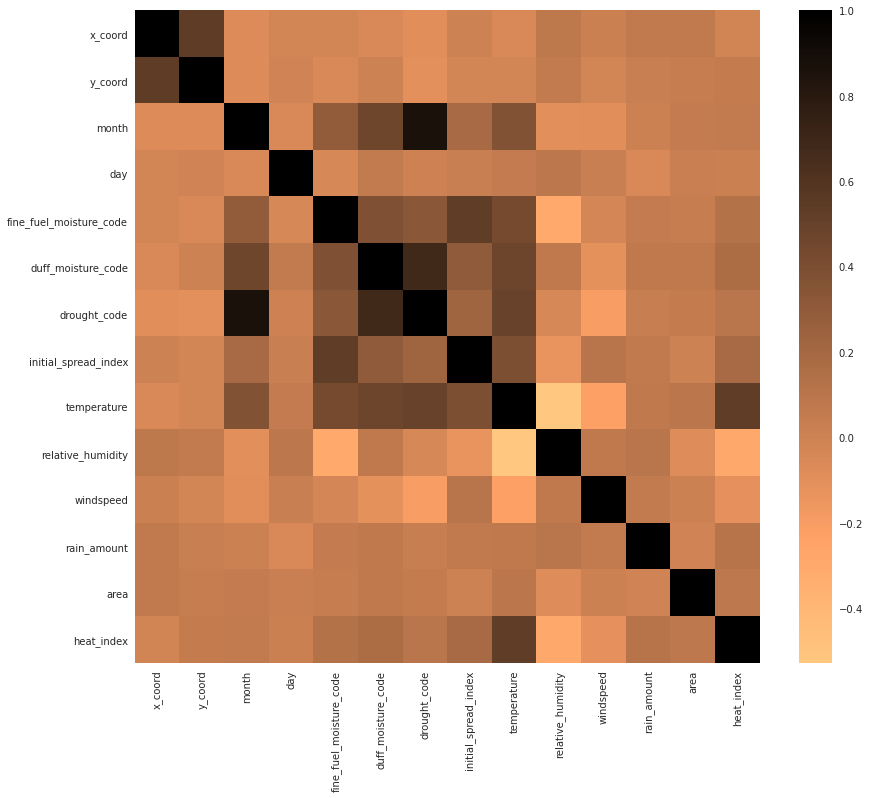

In [12]:
validation = DataValidation(fire_data)
validation.plot_correlation()

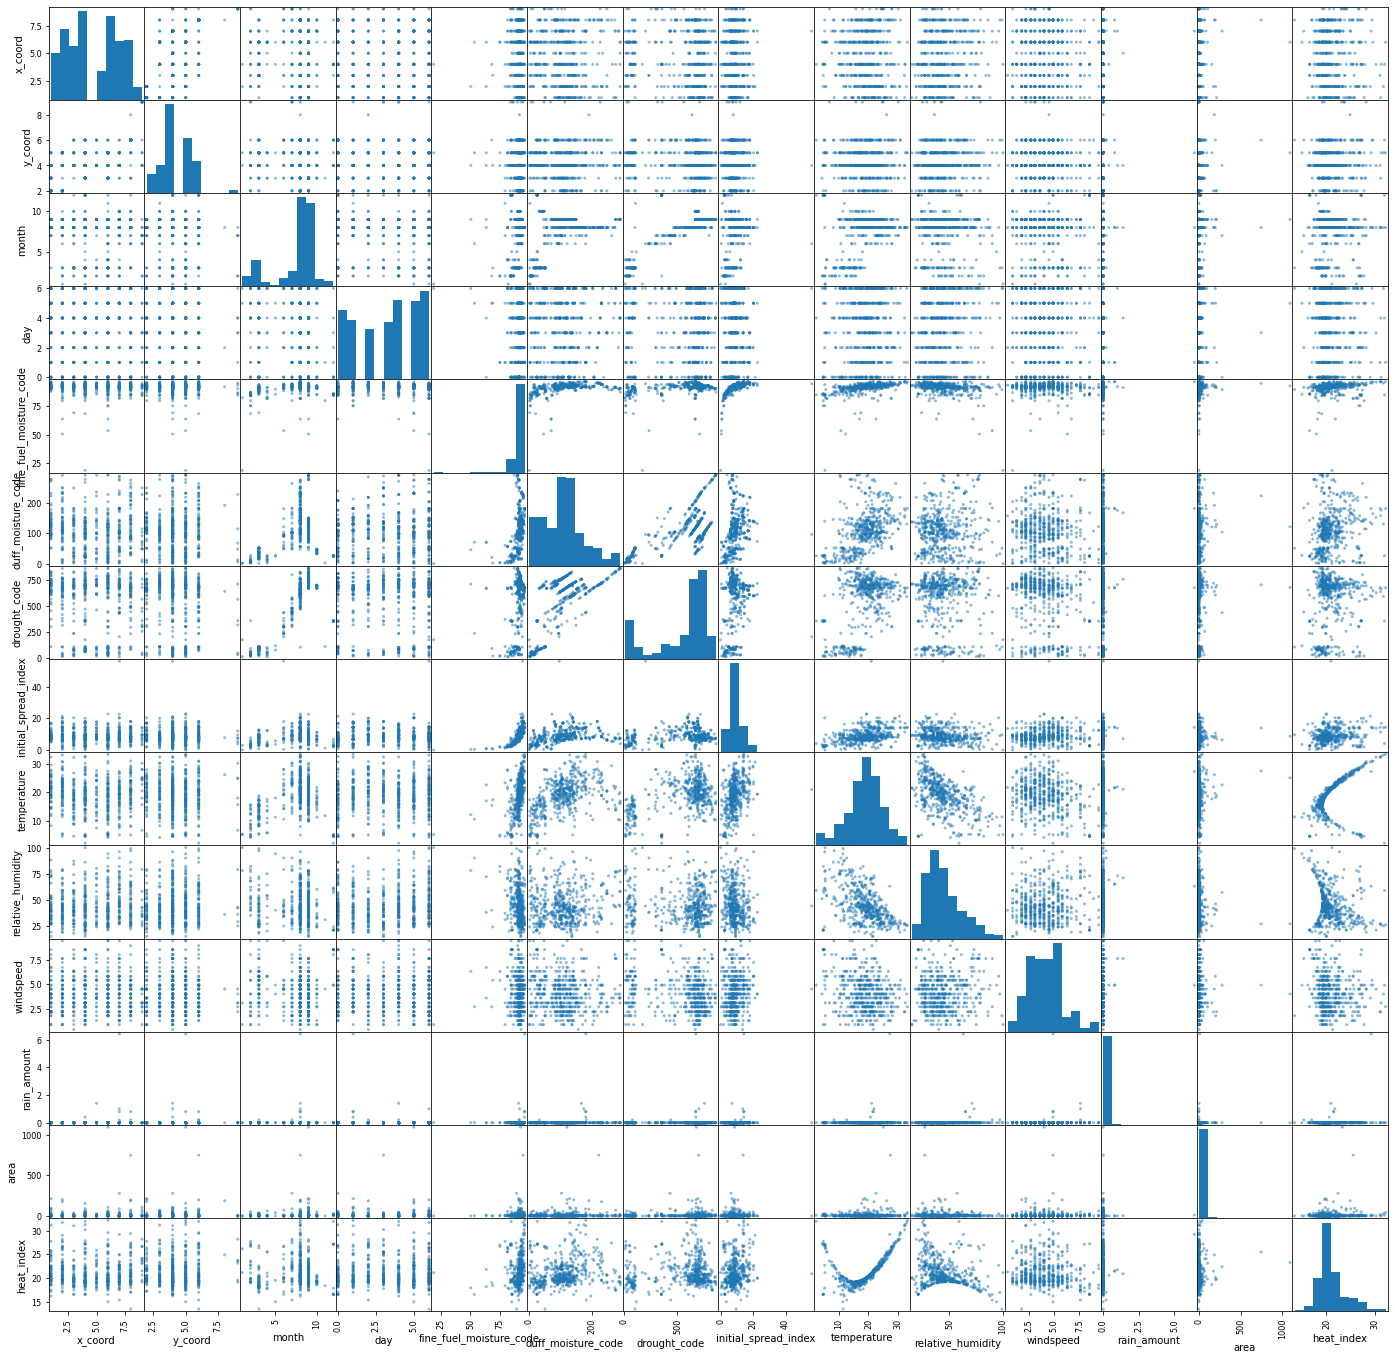

In [13]:
validation.plot_pairwise()

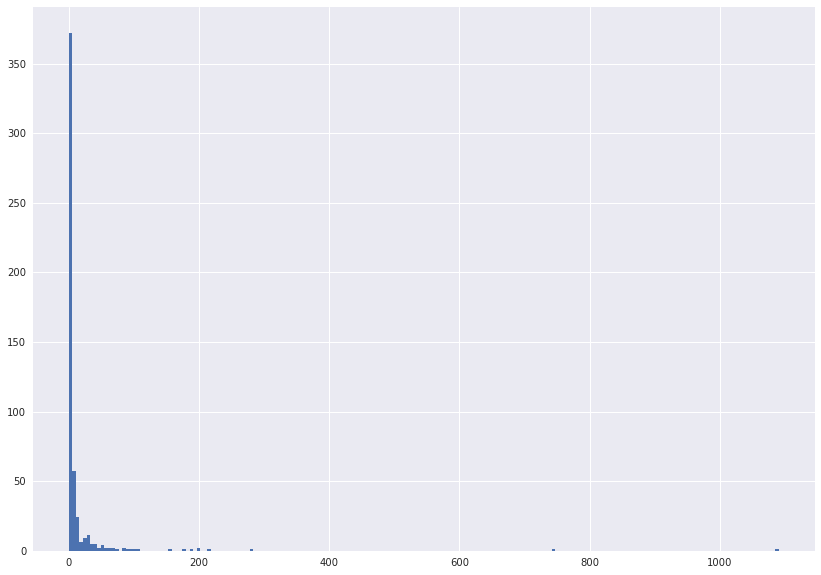

In [14]:
validation.plot_hist("area", 200)

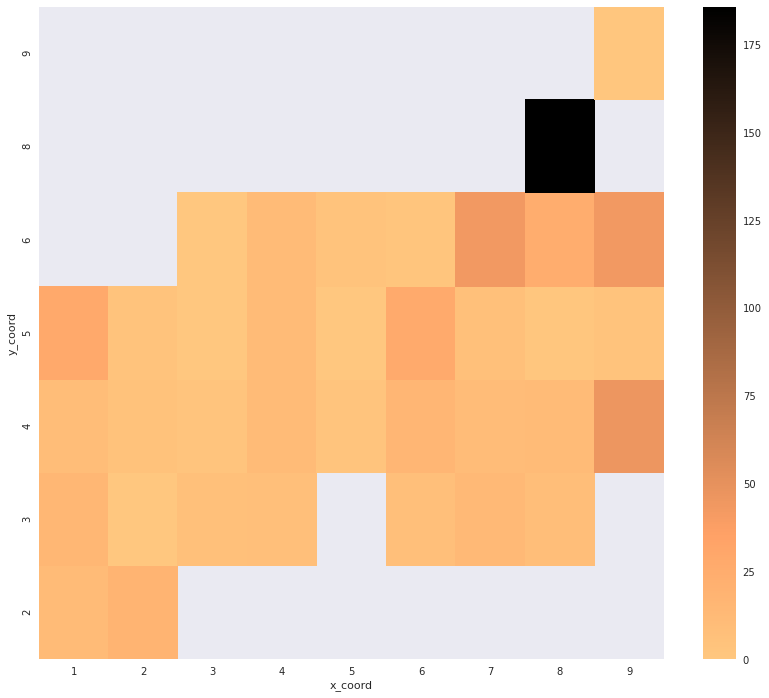

In [15]:
validation.plot_area_map('x_coord', 'y_coord', 'area')

In [16]:
random_forest_tune = RandomForestTuning(fire_data, 'area', 'x_coord', 200, 0.15, 'rmse')
trial_rf = random_forest_tune.run()
final_rf_model = RandomForestBuilder(trial_rf, random_forest_tune).extract_best_and_build()

[I 2021-06-11 18:46:49,911] A new study created in memory with name: no-name-551f49eb-5b02-467a-80e3-04a0b995f61c
[I 2021-06-11 18:46:55,825] Trial 0 finished with value: 16.99726956063431 and parameters: {'n_estimators': 1820, 'max_depth': 22, 'min_samples_split': 6, 'min_samples_leaf': 6, 'max_leaf_nodes': 214, 'min_impurity_decrease': 3.4875912832985715e-17, 'max_features': 'sqrt'}. Best is trial 0 with value: 16.99726956063431.
[I 2021-06-11 18:46:58,734] Trial 1 finished with value: 125.92590699214422 and parameters: {'n_estimators': 970, 'max_depth': 18, 'min_samples_split': 25, 'min_samples_leaf': 11, 'max_leaf_nodes': 259, 'min_impurity_decrease': 5.02855578303244e-08, 'max_features': 'sqrt'}. Best is trial 0 with value: 16.99726956063431.
[I 2021-06-11 18:47:03,237] Trial 2 finished with value: 124.80967769558347 and parameters: {'n_estimators': 1480, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_leaf_nodes': 262, 'min_impurity_decrease': 4.8246171249919

[I 2021-06-11 18:48:29,814] Trial 24 finished with value: 33.53813806479538 and parameters: {'n_estimators': 1360, 'max_depth': 16, 'min_samples_split': 16, 'min_samples_leaf': 17, 'max_leaf_nodes': 296, 'min_impurity_decrease': 8.942702196286284e-20, 'max_features': 'sqrt'}. Best is trial 22 with value: 14.4283737948199.
[I 2021-06-11 18:48:34,268] Trial 25 finished with value: 40.90006901355772 and parameters: {'n_estimators': 1560, 'max_depth': 21, 'min_samples_split': 11, 'min_samples_leaf': 17, 'max_leaf_nodes': 241, 'min_impurity_decrease': 7.039417969011114e-14, 'max_features': 'sqrt'}. Best is trial 22 with value: 14.4283737948199.
[I 2021-06-11 18:48:38,066] Trial 26 finished with value: 22.195680593694792 and parameters: {'n_estimators': 1270, 'max_depth': 13, 'min_samples_split': 15, 'min_samples_leaf': 13, 'max_leaf_nodes': 365, 'min_impurity_decrease': 4.347793147405071e-11, 'max_features': 'sqrt'}. Best is trial 22 with value: 14.4283737948199.
[I 2021-06-11 18:48:42,367]

[I 2021-06-11 18:50:32,073] Trial 49 finished with value: 17.617476791732905 and parameters: {'n_estimators': 1710, 'max_depth': 4, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_leaf_nodes': 158, 'min_impurity_decrease': 4.401786181414668e-19, 'max_features': 'sqrt'}. Best is trial 22 with value: 14.4283737948199.
[I 2021-06-11 18:50:37,748] Trial 50 finished with value: 48.177955817480424 and parameters: {'n_estimators': 1990, 'max_depth': 4, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_leaf_nodes': 255, 'min_impurity_decrease': 3.430920709828984e-20, 'max_features': 'sqrt'}. Best is trial 22 with value: 14.4283737948199.
[I 2021-06-11 18:50:42,669] Trial 51 finished with value: 83.71610495489273 and parameters: {'n_estimators': 1700, 'max_depth': 2, 'min_samples_split': 6, 'min_samples_leaf': 5, 'max_leaf_nodes': 65, 'min_impurity_decrease': 1.2422260818720242e-18, 'max_features': 'sqrt'}. Best is trial 22 with value: 14.4283737948199.
[I 2021-06-11 18:50:47,962] Trial

[I 2021-06-11 18:52:38,477] Trial 74 finished with value: 36.8965371609565 and parameters: {'n_estimators': 1890, 'max_depth': 16, 'min_samples_split': 10, 'min_samples_leaf': 18, 'max_leaf_nodes': 182, 'min_impurity_decrease': 3.860976394716891e-06, 'max_features': 'sqrt'}. Best is trial 22 with value: 14.4283737948199.
[I 2021-06-11 18:52:44,376] Trial 75 finished with value: 17.496546018155794 and parameters: {'n_estimators': 2000, 'max_depth': 21, 'min_samples_split': 9, 'min_samples_leaf': 15, 'max_leaf_nodes': 266, 'min_impurity_decrease': 8.885768632329726e-09, 'max_features': 'sqrt'}. Best is trial 22 with value: 14.4283737948199.
[I 2021-06-11 18:52:49,555] Trial 76 finished with value: 27.13379985939848 and parameters: {'n_estimators': 1820, 'max_depth': 21, 'min_samples_split': 8, 'min_samples_leaf': 15, 'max_leaf_nodes': 264, 'min_impurity_decrease': 2.281560987866316e-08, 'max_features': 'log2'}. Best is trial 22 with value: 14.4283737948199.
[I 2021-06-11 18:52:53,074] Tr

[I 2021-06-11 18:54:45,771] Trial 99 finished with value: 44.68674569308923 and parameters: {'n_estimators': 1790, 'max_depth': 12, 'min_samples_split': 4, 'min_samples_leaf': 18, 'max_leaf_nodes': 170, 'min_impurity_decrease': 1.749230419366087e-05, 'max_features': 'sqrt'}. Best is trial 22 with value: 14.4283737948199.
[I 2021-06-11 18:54:53,469] Trial 100 finished with value: 30.80852168455235 and parameters: {'n_estimators': 1970, 'max_depth': 19, 'min_samples_split': 11, 'min_samples_leaf': 13, 'max_leaf_nodes': 144, 'min_impurity_decrease': 1.1730815787788892e-13, 'max_features': 'sqrt'}. Best is trial 22 with value: 14.4283737948199.
[I 2021-06-11 18:54:56,437] Trial 101 finished with value: 124.43460724396517 and parameters: {'n_estimators': 960, 'max_depth': 17, 'min_samples_split': 10, 'min_samples_leaf': 12, 'max_leaf_nodes': 232, 'min_impurity_decrease': 6.4980901984649465e-21, 'max_features': 'sqrt'}. Best is trial 22 with value: 14.4283737948199.
[I 2021-06-11 18:55:00,24

[I 2021-06-11 18:56:25,733] Trial 124 finished with value: 28.922316804945513 and parameters: {'n_estimators': 900, 'max_depth': 13, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_leaf_nodes': 256, 'min_impurity_decrease': 1.430871610531879e-17, 'max_features': 'sqrt'}. Best is trial 22 with value: 14.4283737948199.
[I 2021-06-11 18:56:29,237] Trial 125 finished with value: 37.37914547795751 and parameters: {'n_estimators': 1160, 'max_depth': 9, 'min_samples_split': 9, 'min_samples_leaf': 4, 'max_leaf_nodes': 205, 'min_impurity_decrease': 2.601141467563704e-19, 'max_features': 'sqrt'}. Best is trial 22 with value: 14.4283737948199.
[I 2021-06-11 18:56:32,400] Trial 126 finished with value: 89.28055863506933 and parameters: {'n_estimators': 1100, 'max_depth': 12, 'min_samples_split': 11, 'min_samples_leaf': 12, 'max_leaf_nodes': 239, 'min_impurity_decrease': 6.903550313142689e-17, 'max_features': 'sqrt'}. Best is trial 22 with value: 14.4283737948199.
[I 2021-06-11 18:56:36,395] Tr

[I 2021-06-11 18:58:27,454] Trial 149 finished with value: 84.94122568252526 and parameters: {'n_estimators': 1600, 'max_depth': 24, 'min_samples_split': 10, 'min_samples_leaf': 7, 'max_leaf_nodes': 73, 'min_impurity_decrease': 4.806410058334048e-19, 'max_features': 'sqrt'}. Best is trial 22 with value: 14.4283737948199.
[I 2021-06-11 18:58:31,901] Trial 150 finished with value: 128.79505956898913 and parameters: {'n_estimators': 1480, 'max_depth': 15, 'min_samples_split': 11, 'min_samples_leaf': 14, 'max_leaf_nodes': 229, 'min_impurity_decrease': 4.078628276770105e-09, 'max_features': 'sqrt'}. Best is trial 22 with value: 14.4283737948199.
[I 2021-06-11 18:58:35,099] Trial 151 finished with value: 15.243395752648322 and parameters: {'n_estimators': 1100, 'max_depth': 17, 'min_samples_split': 10, 'min_samples_leaf': 17, 'max_leaf_nodes': 190, 'min_impurity_decrease': 1.258917292221757e-18, 'max_features': 'sqrt'}. Best is trial 22 with value: 14.4283737948199.
[I 2021-06-11 18:58:38,36

[I 2021-06-11 19:00:32,918] Trial 174 finished with value: 32.706253126412754 and parameters: {'n_estimators': 1700, 'max_depth': 17, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_leaf_nodes': 222, 'min_impurity_decrease': 3.62101307814329e-18, 'max_features': 'sqrt'}. Best is trial 22 with value: 14.4283737948199.
[I 2021-06-11 19:00:37,971] Trial 175 finished with value: 20.575367068262317 and parameters: {'n_estimators': 1620, 'max_depth': 17, 'min_samples_split': 12, 'min_samples_leaf': 10, 'max_leaf_nodes': 175, 'min_impurity_decrease': 3.079416298971361e-17, 'max_features': 'sqrt'}. Best is trial 22 with value: 14.4283737948199.
[I 2021-06-11 19:00:43,147] Trial 176 finished with value: 39.63209283503488 and parameters: {'n_estimators': 1650, 'max_depth': 16, 'min_samples_split': 6, 'min_samples_leaf': 12, 'max_leaf_nodes': 244, 'min_impurity_decrease': 1.2840961769224104e-06, 'max_features': 'sqrt'}. Best is trial 22 with value: 14.4283737948199.
[I 2021-06-11 19:00:45,60

[I 2021-06-11 19:02:22,250] Trial 199 finished with value: 43.148909898763655 and parameters: {'n_estimators': 1780, 'max_depth': 16, 'min_samples_split': 7, 'min_samples_leaf': 5, 'max_leaf_nodes': 215, 'min_impurity_decrease': 8.3777426198552e-19, 'max_features': 'sqrt'}. Best is trial 22 with value: 14.4283737948199.


In [17]:
plot_optimization_history(trial_rf)

In [18]:
plot_slice(trial_rf)

In [19]:
plot_param_importances(trial_rf)

In [20]:
plot_edf(trial_rf)

In [21]:
shap_obj = ShapObject(final_rf_model.model, final_rf_model.X)

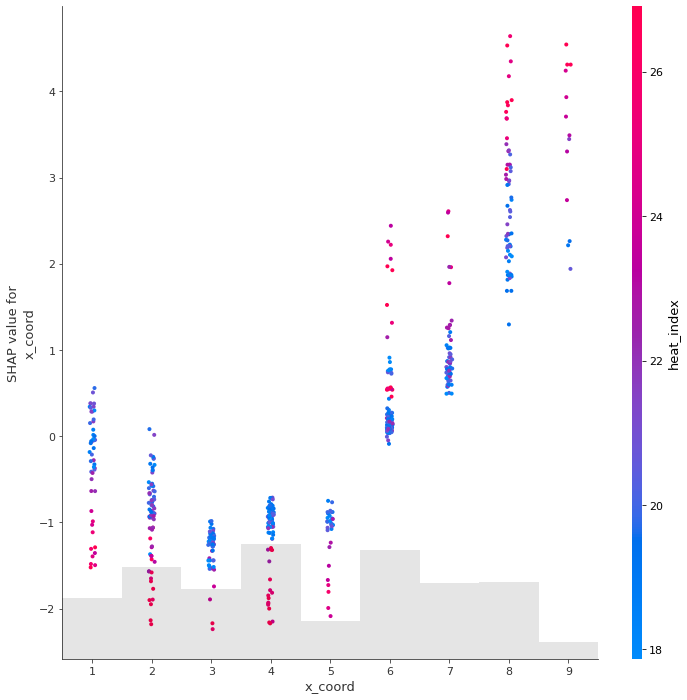

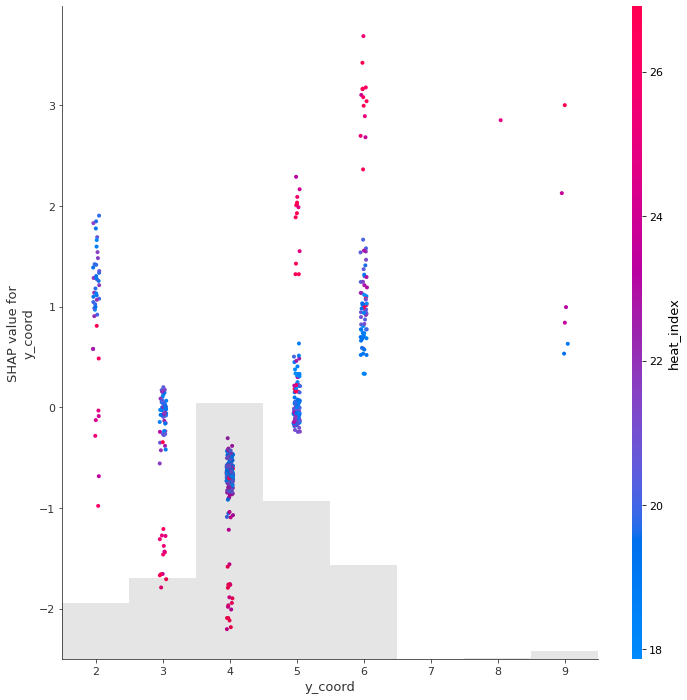

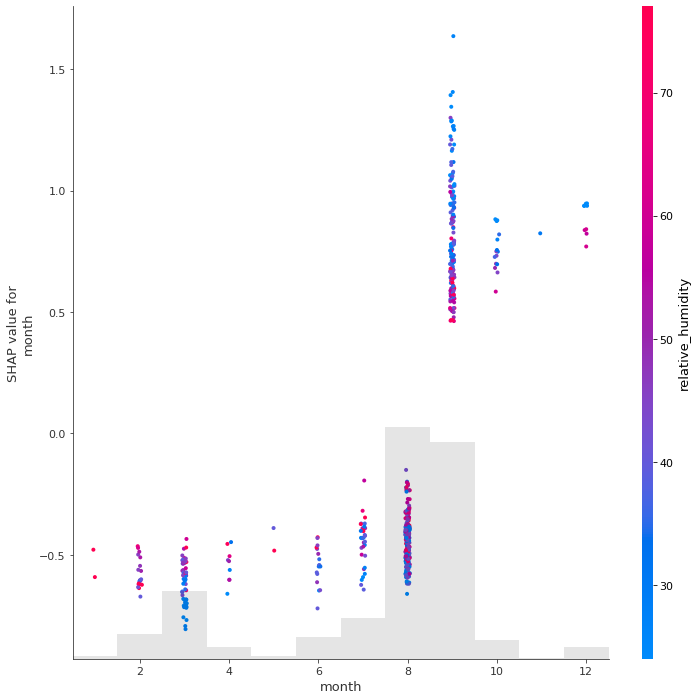

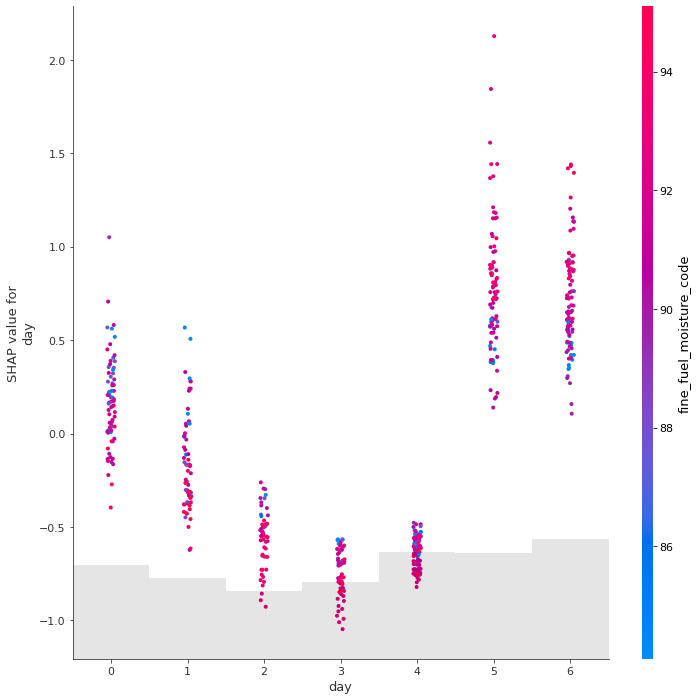

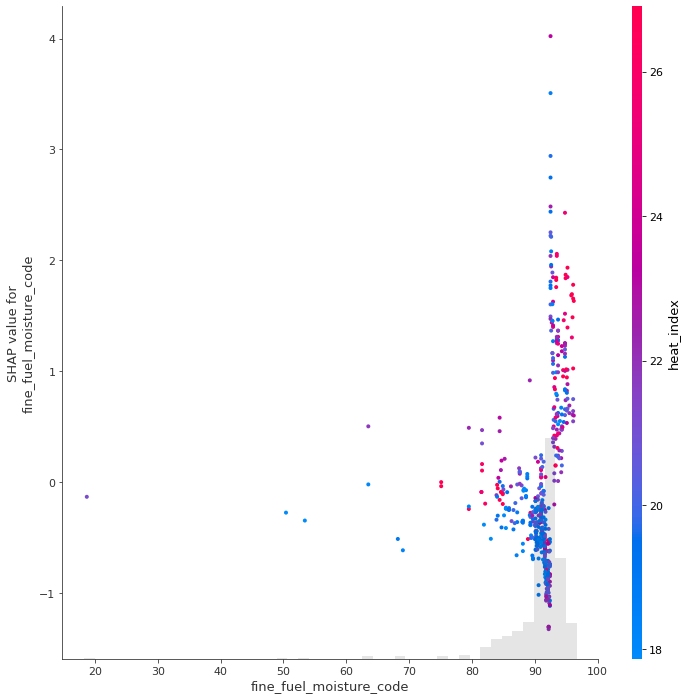

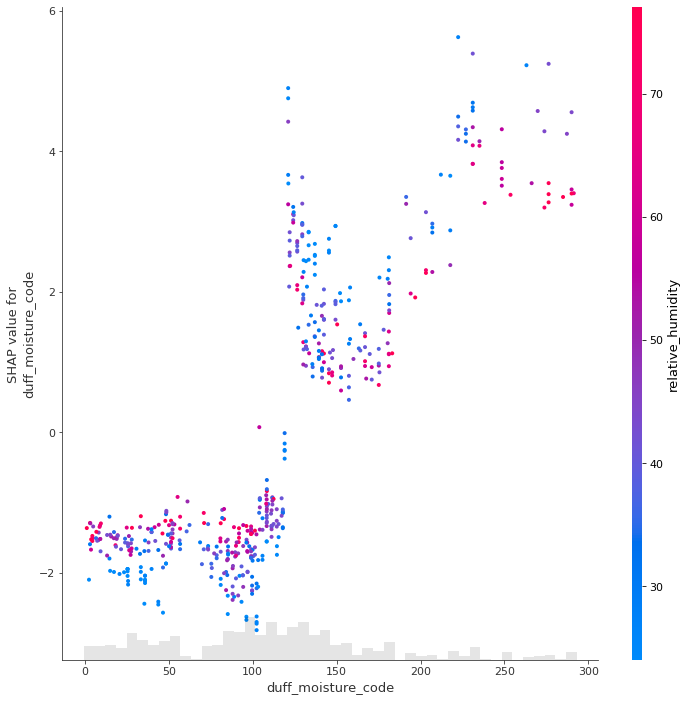

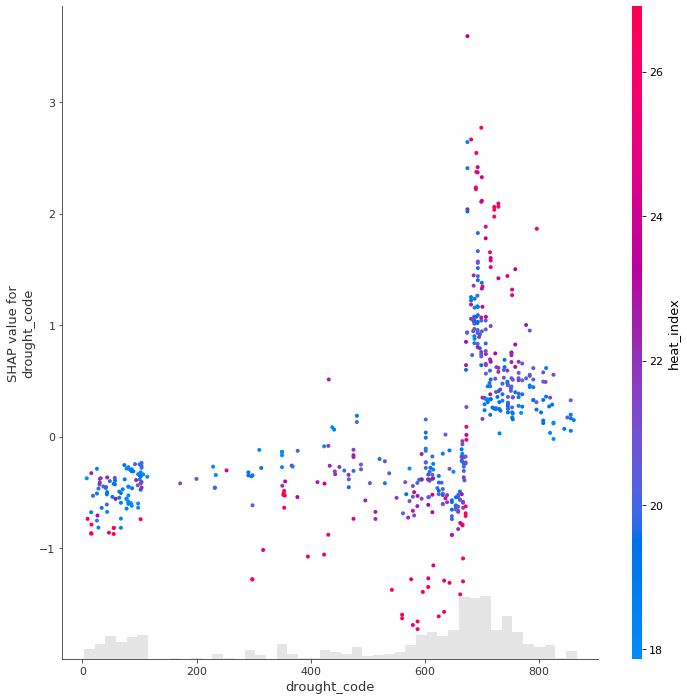

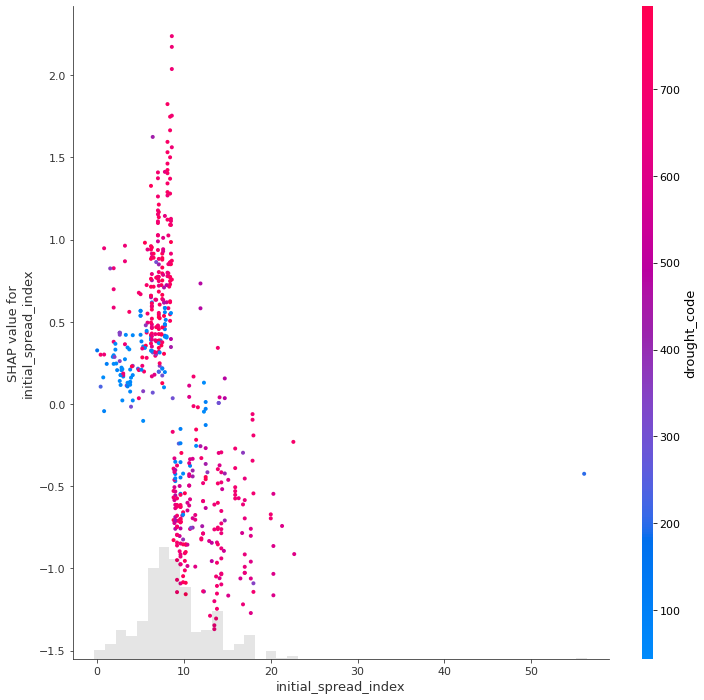

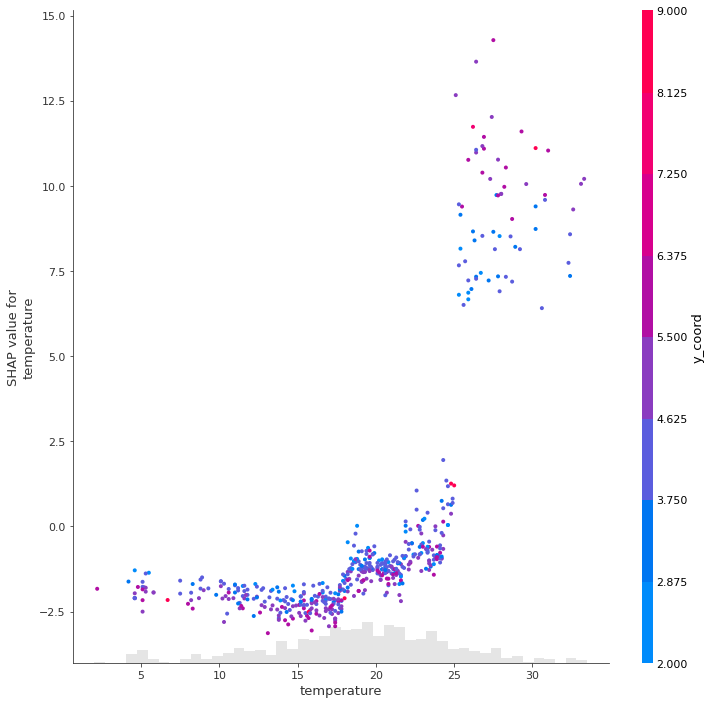

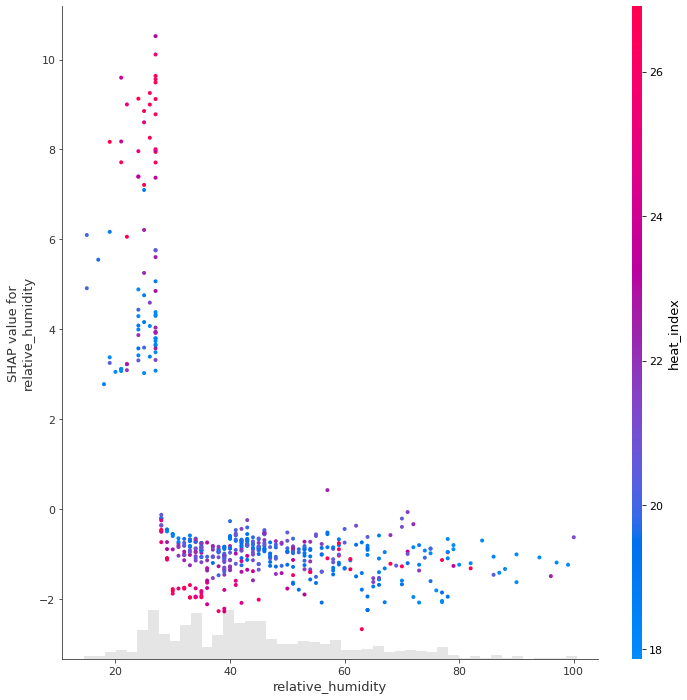

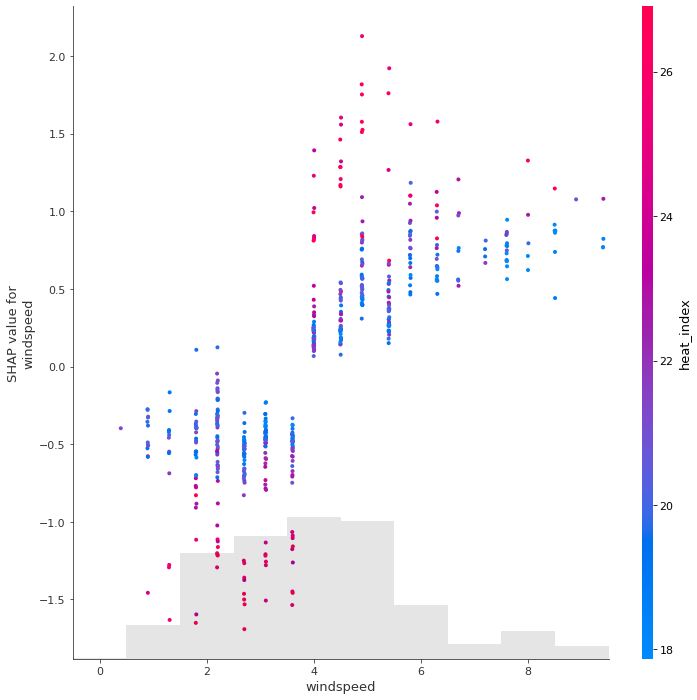

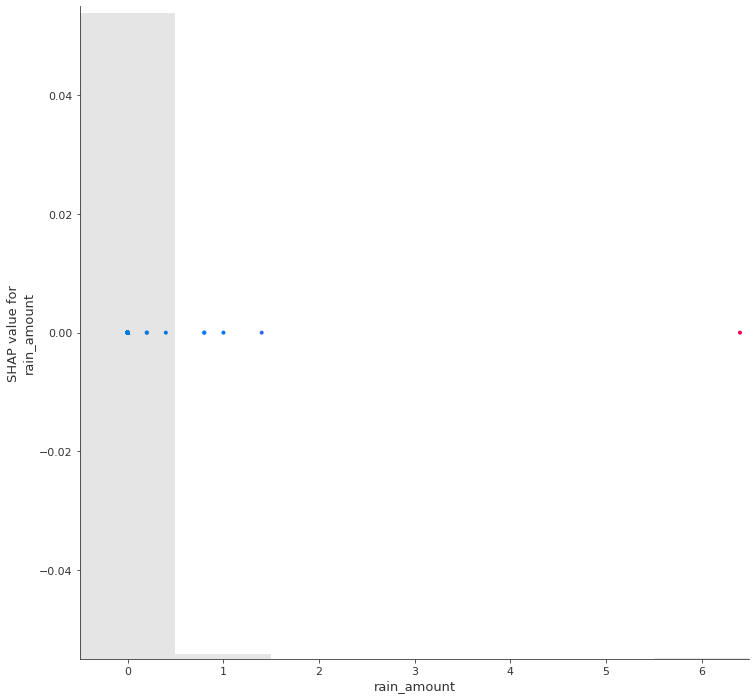

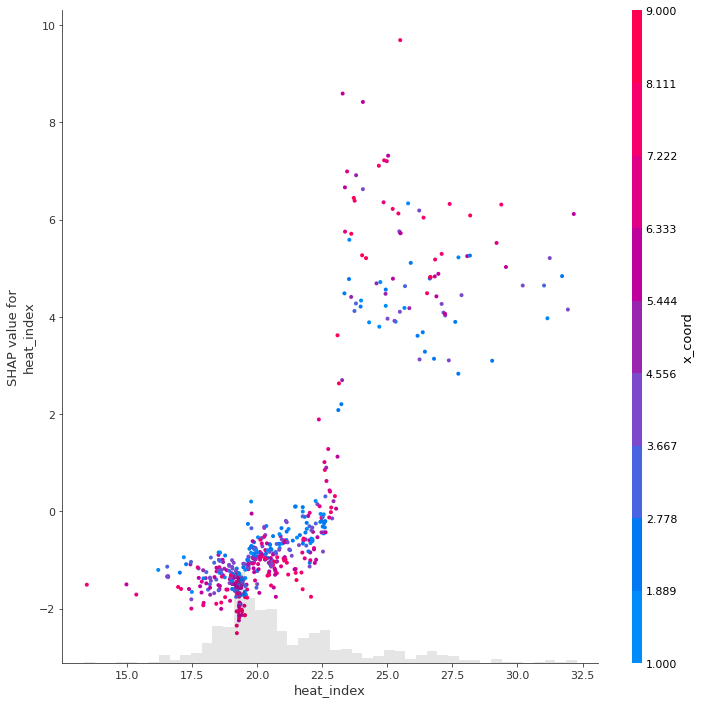

In [22]:
scatter_plots = [shap_obj.plot_scatter(x) for x in final_rf_model.X.columns]

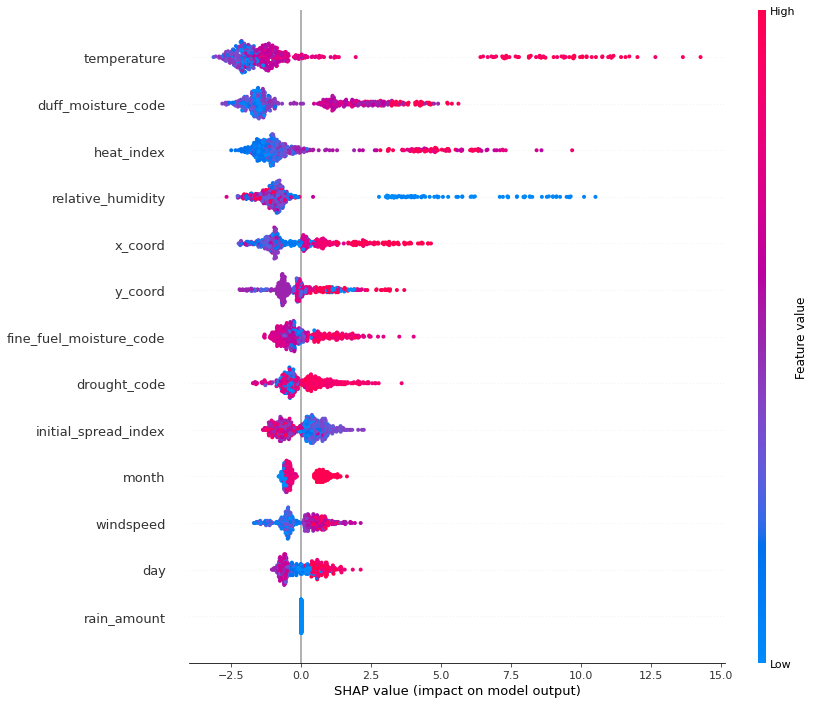

In [23]:
shap_obj.plot_summary()

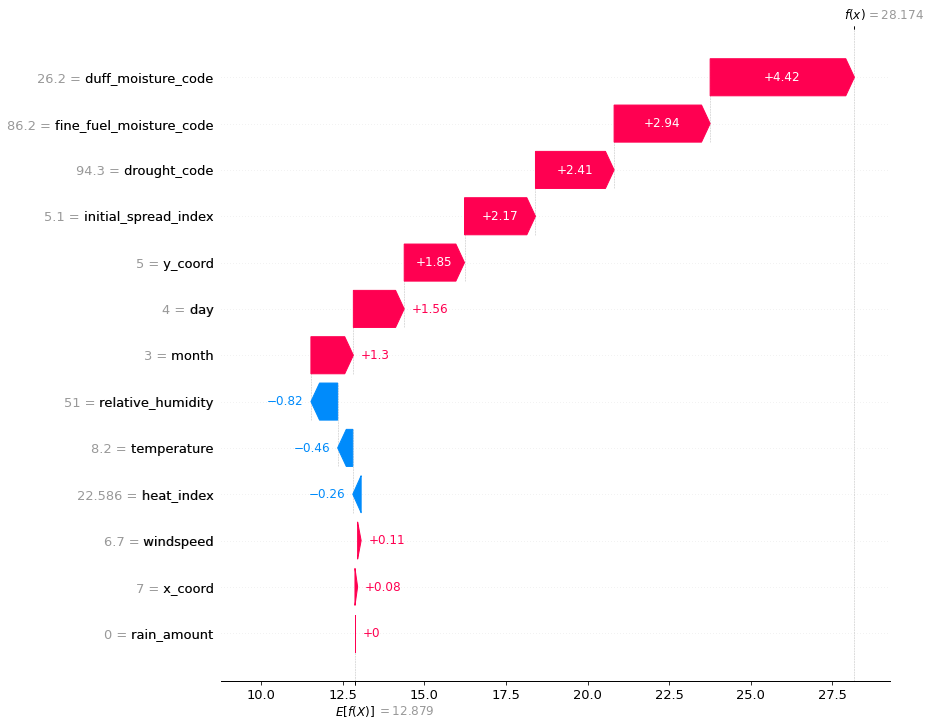

In [24]:
interesting_rows = fire_data.nlargest(5, 'area').reset_index()['index'].values
waterfalls = [shap_obj.plot_waterfall(x) for x in interesting_rows]

<Figure size 432x288 with 0 Axes>

<Figure size 1440x216 with 0 Axes>

<Figure size 1440x216 with 0 Axes>

<Figure size 1440x216 with 0 Axes>

<Figure size 1440x216 with 0 Axes>

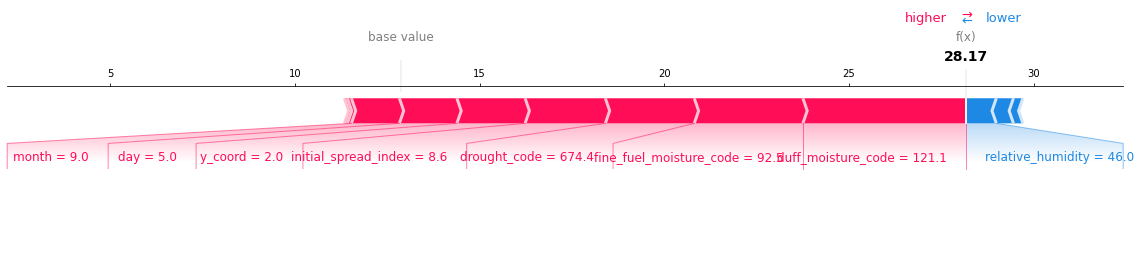

In [25]:
force_by_row = [shap_obj.plot_force_by_row(x) for x in interesting_rows]

In [26]:
shap_obj.plot_full_force()

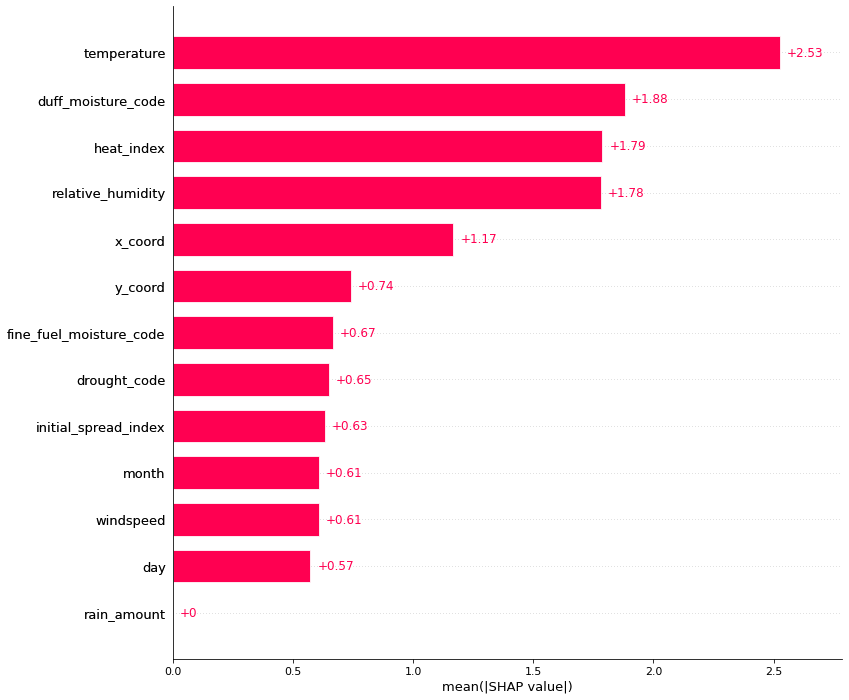

In [27]:
shap_obj.plot_shap_importances()